### **YifeiProject1:** Analyzing relationships between cancer rates and death rates AND access to insurance and clinical trials across all states and counties in the US

In [83]:
# Dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

ModuleNotFoundError: No module named 'statsmodels'

In [85]:
# Read the avg-household-size data into a DataFrame
df_household_size = pd.read_csv("Resources/avg-household-size.csv", index_col='geography')
df_household_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3220 entries, Aleutians East Borough, Alaska to Weston County, Wyoming
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             3220 non-null   int64  
 1   statefips         3220 non-null   int64  
 2   countyfips        3220 non-null   int64  
 3   avghouseholdsize  3220 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 125.8+ KB


In [87]:
# Dislay the dataframe of geography vs. household size in Resources/avg-household-size.csv
display(pd.concat([df_household_size.head(), df_household_size.tail()]))

,index,statefips,countyfips,avghouseholdsize
geography,,,,
"Aleutians East Borough, Alaska",0,2,13,2.43
"Aleutians West Census Area, Alaska",1,2,16,3.59
"Anchorage Municipality, Alaska",2,2,20,2.77
"Bethel Census Area, Alaska",3,2,50,3.86
"Bristol Bay Borough, Alaska",4,2,60,2.50
"Sweetwater County, Wyoming",3215,56,37,2.64
"Teton County, Wyoming",3216,56,39,2.63
"Uinta County, Wyoming",3217,56,41,2.76
"Washakie County, Wyoming",3218,56,43,2.34


In [89]:
# Read the cancer data into a DataFrame and display information about the DataFrame, While set 'geography' as index column
df_cancer_data = pd.read_csv("Resources/cancer_reg.csv", index_col='geography')
df_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3047 entries, Kitsap County, Washington to Geary County, Kansas
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    3047 non-null   int64  
 1   avganncount              3047 non-null   float64
 2   avgdeathsperyear         3047 non-null   int64  
 3   target_deathrate         3047 non-null   float64
 4   incidencerate            3047 non-null   float64
 5   medincome                3047 non-null   int64  
 6   popest2015               3047 non-null   int64  
 7   povertypercent           3047 non-null   float64
 8   studypercap              3047 non-null   float64
 9   binnedinc                3047 non-null   object 
 10  medianage                3047 non-null   float64
 11  medianagemale            3047 non-null   float64
 12  medianagefemale          3047 non-null   float64
 13  percentmarried           3047 non-null   fl

In [91]:
# Display how many non-null in 'geography' in both files
# For cancer_reg.csv
print(df_cancer_data.index.notnull().sum())

# For avg-household-size.csv
print(df_household_size.index.notnull().sum())

3047
3220


In [93]:
# Clean the household size dataframe and find the MAX and the MIN household size
df_household_size = df_household_size.drop(columns='index')
print(f"Minimum household size is {df_household_size['avghouseholdsize'].min()}")
print(f"Maximum household size is {df_household_size['avghouseholdsize'].max()}")

Minimum household size is 1.37
Maximum household size is 4.73


In [95]:
# Dislay the dataframe of geography etc. in Resources/cancer_reg.csv
df_cancer_data = df_cancer_data.drop(columns='index')
display(pd.concat([df_cancer_data.head(), df_cancer_data.tail()]))


,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
geography,,,,,,,,,,,,,,,,,,,,,
"Kitsap County, Washington",1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
"Kittitas County, Washington",173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
"Klickitat County, Washington",102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
"Lewis County, Washington",427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
"Lincoln County, Washington",57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
"Ellsworth County, Kansas",1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
"Finney County, Kansas",1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
"Ford County, Kansas",1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
"Franklin County, Kansas",1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [97]:
# Combine two .csv by index'geography' and exclude N/A
df_combined = pd.merge(df_household_size, df_cancer_data, on="geography", how="inner")
display(pd.concat([df_combined.head(), df_combined.tail()]))

,statefips,countyfips,avghouseholdsize,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
geography,,,,,,,,,,,,,,,,,,,,,
"Aleutians West Census Area, Alaska",2,16,3.59,8.0,3,203.3,201.3,68387,5702,9.9,...,60.4,58.3,11.2,6.2,31.562280,4.732583,37.156932,5.295567,42.882250,4.391052
"Anchorage Municipality, Alaska",2,20,2.77,1085.0,352,167.5,453.3,75200,298695,10.0,...,NaN,45.9,24.5,12.9,64.944652,5.854427,8.800530,1.747201,48.361303,5.994294
"Bethel Census Area, Alaska",2,50,3.86,37.0,20,218.8,338.2,45808,17946,23.8,...,25.8,25.1,47.3,36.1,12.016202,0.798830,1.175743,0.343159,45.521390,9.156280
"Dillingham Census Area, Alaska",2,70,3.56,16.0,7,216.6,409.2,51082,4997,17.5,...,29.1,28.6,41.2,30.2,18.718618,0.341434,1.446074,0.482025,46.478873,11.801242
"Fairbanks North Star Borough, Alaska",2,90,2.69,307.0,105,177.2,424.4,67801,99631,9.5,...,59.8,43.9,22.2,10.4,76.649115,4.352841,2.628755,0.891630,50.354112,7.382578
"Sweetwater County, Wyoming",56,37,2.64,155.0,49,141.1,403.5,72604,44626,9.8,...,62.7,59.0,21.9,11.3,92.133476,0.866613,0.857679,1.684088,54.385755,8.929776
"Teton County, Wyoming",56,39,2.63,83.0,23,136.9,402.7,75348,23125,7.7,...,67.2,46.1,14.4,5.5,93.160325,0.322711,1.900408,2.783380,50.580188,1.745232
"Uinta County, Wyoming",56,41,2.76,68.0,24,132.8,359.3,56800,20822,10.0,...,NaN,54.1,24.4,13.0,94.233158,0.195891,0.119446,1.538462,57.451346,6.918372
"Washakie County, Wyoming",56,43,2.34,50.0,21,182.3,448.0,50802,8328,12.6,...,49.3,43.8,32.2,13.9,91.238095,0.678571,0.166667,4.142857,51.708428,5.370370


In [99]:
# Display the length of combined dataframe excluding the missing data
len(df_combined)

3047

In [101]:
# Replace blank cells in 'pctprivatecoveragealone' with the mean of the column
df_combined['pctprivatecoveragealone'] = df_combined['pctprivatecoveragealone'].fillna(df_combined['pctprivatecoveragealone'].mean())

# Replace specific values in 'avganncount' and 'incidencerate' with the mean of their respective columns
mean_avganncount = df_combined.loc[df_combined['avganncount'] != 1962.668, 'avganncount'].mean()
df_combined['avganncount'] = df_combined['avganncount'].replace(1962.668, mean_avganncount)

mean_incidencerate = df_combined.loc[df_combined['incidencerate'] != 453.5494221, 'incidencerate'].mean()
df_combined['incidencerate'] = df_combined['incidencerate'].replace(453.5494221, mean_incidencerate)

# Recalculate the actual death rate and actual incidence rate after replacements
df_combined['pctdeathrate'] = df_combined['avgdeathsperyear'] * 100 / df_combined['popest2015']
df_combined['pctincidencerate'] = df_combined['avganncount'] * 100 / df_combined['popest2015']

In [103]:
# Summary statistics
print(df_combined.describe())

         statefips   countyfips  avghouseholdsize   avganncount  \
count  3047.000000  3047.000000       3047.000000   3047.000000   
mean     30.272071   101.802429          2.529682    606.338544   
std      15.054873   104.315612          0.248449   1416.356223   
min       1.000000     1.000000          1.860000      6.000000   
25%      19.000000    35.000000          2.380000     76.000000   
50%      29.000000    79.000000          2.500000    171.000000   
75%      45.000000   133.000000          2.640000    518.000000   
max      56.000000   840.000000          3.970000  38150.000000   

       avgdeathsperyear  target_deathrate  incidencerate      medincome  \
count       3047.000000       3047.000000    3047.000000    3047.000000   
mean         185.965868        178.664063     447.885674   47063.281917   
std          504.134286         27.751511      54.542193   12040.090836   
min            3.000000         59.700000     201.300000   22640.000000   
25%           28.0000

In [105]:
# Calculate the correlation matrix for the selected columns in the dataframe df_combined
df_combined[['popest2015', 'avganncount', 'avgdeathsperyear', 'pctincidencerate', 'pctdeathrate', 'avghouseholdsize']].corr()
# Guidelines for Interpreting Correlation Coefficients:
# 0.0 to ±0.1: Negligible correlation. The relationship between the variables is very weak or nonexistent.
# ±0.1 to ±0.3: Small correlation. There is a slight relationship, but it may not be meaningful in practice.
# ±0.3 to ±0.5: Moderate correlation. There is a noticeable relationship, and it may be meaningful, depending on the context.
# ±0.5 to ±0.7: Strong correlation. The relationship is substantial and likely to be meaningful.
# ±0.7 to ±1.0: Very strong correlation. The relationship is very strong and almost certainly meaningful.

,popest2015,avganncount,avgdeathsperyear,pctincidencerate,pctdeathrate,avghouseholdsize
popest2015,1.000000,0.926894,0.977634,-0.051793,-0.242346,0.164570
avganncount,0.926894,1.000000,0.939408,0.161177,-0.187947,0.089521
avgdeathsperyear,0.977634,0.939408,1.000000,-0.058873,-0.200451,0.127565
pctincidencerate,-0.051793,0.161177,-0.058873,1.000000,0.139774,-0.136847
pctdeathrate,-0.242346,-0.187947,-0.200451,0.139774,1.000000,-0.559891
avghouseholdsize,0.164570,0.089521,0.127565,-0.136847,-0.559891,1.000000


In [107]:
# Selected code: defining lists of column names for different categories
insurance_cols = ['pctprivatecoverage', 'pctprivatecoveragealone', 'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone']  # columns related to insurance coverage
clinical_trial_col = ['studypercap']  # column related to clinical trials
cancer_cols = ['popest2015', 'avganncount', 'avgdeathsperyear', 'pctincidencerate', 'pctdeathrate']  # columns related to cancer statistics

In [109]:
# Calculate the correlation matrix for the selected columns in the combined dataframe
df_combined[cancer_cols + insurance_cols].corr()


,popest2015,avganncount,avgdeathsperyear,pctincidencerate,pctdeathrate,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone
popest2015,1.000000,0.926894,0.977634,-0.051793,-0.242346,0.052677,0.121365,0.158650,-0.160066,-0.041469
avganncount,0.926894,1.000000,0.939408,0.161177,-0.187947,0.132244,0.166674,0.202349,-0.173548,-0.093699
avgdeathsperyear,0.977634,0.939408,1.000000,-0.058873,-0.200451,0.056183,0.112221,0.160124,-0.131687,-0.027338
pctincidencerate,-0.051793,0.161177,-0.058873,1.000000,0.139774,0.128061,0.064304,0.022330,-0.054719,-0.133850
pctdeathrate,-0.242346,-0.187947,-0.200451,0.139774,1.000000,-0.205860,-0.371131,-0.413621,0.625699,0.315031
pctprivatecoverage,0.052677,0.132244,0.056183,0.128061,-0.205860,1.000000,0.834903,0.827459,-0.720012,-0.886234
pctprivatecoveragealone,0.121365,0.166674,0.112221,0.064304,-0.371131,0.834903,1.000000,0.831723,-0.770221,-0.769590
pctempprivcoverage,0.158650,0.202349,0.160124,0.022330,-0.413621,0.827459,0.831723,1.000000,-0.778315,-0.728823
pctpubliccoverage,-0.160066,-0.173548,-0.131687,-0.054719,0.625699,-0.720012,-0.770221,-0.778315,1.000000,0.865833
pctpubliccoveragealone,-0.041469,-0.093699,-0.027338,-0.133850,0.315031,-0.886234,-0.769590,-0.728823,0.865833,1.000000


In [111]:
!pip install seaborn

In [112]:
import seaborn as sns

In [113]:
# Calculate the correlation matrix for the combined selected columns
corr_matrix = df_combined[cancer_cols + insurance_cols].corr()


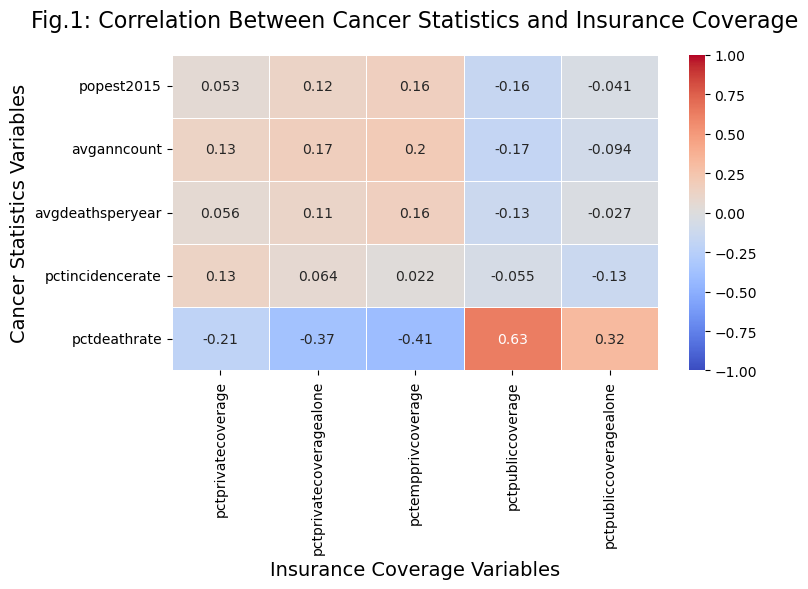

In [114]:
# Filter the correlation matrix to only show the relationship between cancer_cols and insurance_cols
corr_matrix_filtered = corr_matrix.loc[cancer_cols, insurance_cols]

# Plot the heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Add labels and title
plt.xlabel('Insurance Coverage Variables', fontsize=14)
plt.ylabel('Cancer Statistics Variables', fontsize=14)
plt.title('Fig.1: Correlation Between Cancer Statistics and Insurance Coverage', fontsize=16, pad=20)

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Fig.1_Correlation_Between_Cancer_Statistics_and_Insurance_Coverage.png', bbox_inches='tight')

# Show the plot
plt.show()

In [115]:
df_combined[cancer_cols + clinical_trial_col].corr()

,popest2015,avganncount,avgdeathsperyear,pctincidencerate,pctdeathrate,studypercap
popest2015,1.000000,0.926894,0.977634,-0.051793,-0.242346,0.055722
avganncount,0.926894,1.000000,0.939408,0.161177,-0.187947,0.082071
avgdeathsperyear,0.977634,0.939408,1.000000,-0.058873,-0.200451,0.063488
pctincidencerate,-0.051793,0.161177,-0.058873,1.000000,0.139774,-0.004815
pctdeathrate,-0.242346,-0.187947,-0.200451,0.139774,1.000000,-0.012375
studypercap,0.055722,0.082071,0.063488,-0.004815,-0.012375,1.000000


### **Key Observations**

- **`pctdeathrate` (Cancer death rate)** has a **strong positive correlation (0.63)** with **`pctpubliccoverage`** (percentage of people with only public health insurance). This suggests that counties with higher public health insurance coverage alone might have higher cancer death rates.
  
- **`pctdeathrate`** also has a **moderate negative correlation** with **`pctempprivcoverage`** (-0.41), indicating that higher private health insurance coverage might be associated with lower cancer death rates.

- Other correlations in the matrix are generally **weak or moderate**, suggesting varying degrees of relationships between cancer statistics and different types of insurance coverage.


 ### **Possible Explanations for the Correlations**

1. **Positive Correlation Between `pctdeathrate` and `pctpubliccoverage` (0.63):**
   - **Socioeconomic Factors:** Higher public health insurance coverage might indicate a population with lower socioeconomic status, which often correlates with higher mortality rates due to limited access to quality healthcare, preventive services, and timely medical interventions.
   - **Healthcare Accessibility:** Individuals relying solely on public coverage might face longer wait times, less access to specialized care, and fewer treatment options, leading to worse outcomes in severe health conditions like cancer.
  
2. **Negative Correlation Between `pctdeathrate` and `pctempprivcoverage` (-0.41):**
   - **Better Healthcare Access:** Employment-based private insurance often provides better access to high-quality healthcare services, including earlier detection, more aggressive treatment options, and comprehensive follow-up care, leading to lower death rates.
   - **Preventive Measures:** People with employer-provided private insurance might have better access to preventive measures such as regular screenings, vaccinations, and lifestyle interventions, reducing cancer incidence and mortality.

3. **Weak or Moderate Correlations Between Other Variables:**
   - **Diverse Factors:** Cancer statistics and insurance coverage are influenced by numerous factors, including but not limited to environmental exposures, lifestyle choices, and genetic predispositions, which can dilute the strength of correlations between specific variables.


In [118]:
# Calculate the correlation matrix for the combined selected columns
clinical_matrix = df_combined[cancer_cols + clinical_trial_col].corr()

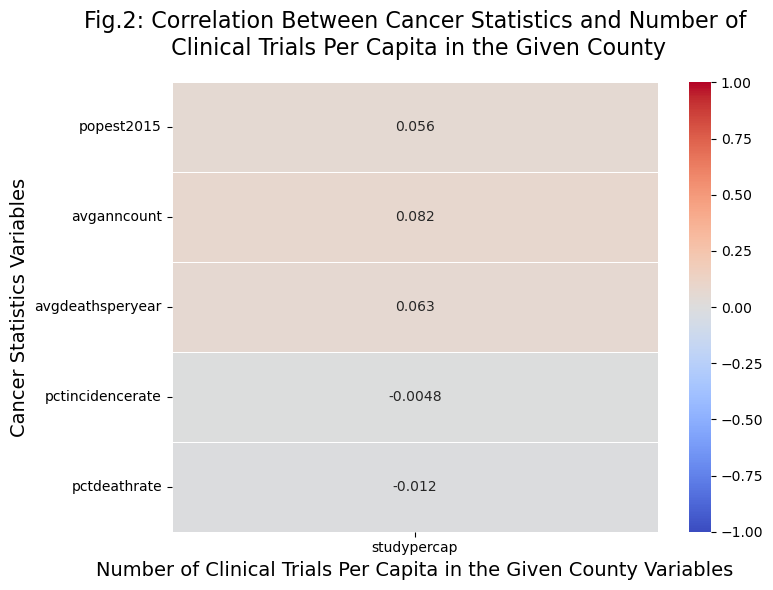

In [119]:
# Filter the correlation matrix to only show the relationship between cancer_cols and insurance_cols
clinical_matrix_filtered = clinical_matrix.loc[cancer_cols, clinical_trial_col]

# Plot the heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(clinical_matrix_filtered, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Add labels and title
plt.xlabel('Number of Clinical Trials Per Capita in the Given County Variables', fontsize=14)
plt.ylabel('Cancer Statistics Variables', fontsize=14)
plt.title('Fig.2: Correlation Between Cancer Statistics and Number of\n Clinical Trials Per Capita in the Given County', fontsize=16, pad=20)

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Fig.2: Correlation_Between_Cancer_Statistics_and_Number_of_Clinical_Trials_Per_Capita_in_the_Given_County.png', bbox_inches='tight')

# Show the plot
plt.show()


In [120]:
# Relationship between cancer incidence and death rates
# and insurance coverage and study coverage?
df_combined[insurance_cols + clinical_trial_col].corr()

,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,studypercap
pctprivatecoverage,1.000000,0.834903,0.827459,-0.720012,-0.886234,0.092545
pctprivatecoveragealone,0.834903,1.000000,0.831723,-0.770221,-0.769590,0.068599
pctempprivcoverage,0.827459,0.831723,1.000000,-0.778315,-0.728823,0.100063
pctpubliccoverage,-0.720012,-0.770221,-0.778315,1.000000,0.865833,-0.051497
pctpubliccoveragealone,-0.886234,-0.769590,-0.728823,0.865833,1.000000,-0.055512
studypercap,0.092545,0.068599,0.100063,-0.051497,-0.055512,1.000000


### **Conclusion:**

1. **Insurance coverage types** may have a **significant impact** on cancer death rates, with **public insurance** showing a stronger positive correlation with higher cancer death rates.

2. The **number of clinical trials per capita** has a **weak correlation** with cancer statistics, suggesting that other factors may play a more significant role in influencing cancer outcomes.


### **Supplementary Information**

In the process of data preparation, I have taken careful steps to ensure that the analysis is based on a robust and complete dataset. Specifically:

- **Data Cleaning:** For any cells that contained NA (Not Available) or were left blank, I used the mean of the other cells in the respective column to fill these missing values. This approach ensures that no rows were eliminated from the analysis, allowing other useful information in those rows to be utilized effectively in subsequent analysis. By preserving the data integrity and volume, the resulting correlations and trends observed are more reliable and less prone to bias from missing data.

- **Observation on `pctempprivcoverage` and `pctpubliccoverage`:** The quantity of data in the columns `pctempprivcoverage` and `pctpubliccoverage` is almost similar, which provides a balanced basis for comparison. Additionally, I employed various plots to test for skewness in these columns, confirming that the data is relatively symmetric and the correlations identified are likely valid. While there may be other explanations for the relationships observed, such as variations in data completeness or underlying demographic factors, the rigorous cleaning and testing of the data suggest that the correlations reflect genuine trends rather than artifacts of incomplete or skewed data.


### **Supplementary Figure Explanation**

To ensure the robustness of the correlations observed in my main analysis, I have included supplementary figures that examine the distribution characteristics of the key variables involved, namely `pctpubliccoverage` and `pctempprivcoverage`. The purpose of these supplementary analyses is to verify that the relatively strong correlations reported were not unduly influenced by skewed data or outliers. Below is an explanation of each supplementary figure and its relevance to my analysis:

1. **Linear Regression Plots:**
   - **Purpose:** The linear regression plots for `pctpubliccoverage` vs. `pctdeathrate` and `pctempprivcoverage` vs. `pctdeathrate` were included to visually assess the relationship between these variables. By plotting the regression line and the individual data points, I aimed to confirm that the observed correlations were consistent across the data range and not driven by a small subset of points.
   - **Interpretation:** The relatively even distribution of data points around the regression line in both plots suggests that the correlations are indeed reflective of the overall trend in the data, rather than being driven by outliers or extreme values.

2. **Box Plots with Data Points:**
   - **Purpose:** The box plots, overlaid with individual data points, were included to visualize the central tendency, variability, and potential outliers in the distributions of `pctpubliccoverage` and `pctempprivcoverage`. These plots allow for a straightforward examination of whether the data is symmetrically distributed or if any significant skewness or outliers might be affecting the correlations.
   - **Interpretation:** The box plots reveal that both `pctpubliccoverage` and `pctempprivcoverage` exhibit relatively symmetric distributions, with no excessive outliers or skewness. This supports the validity of the correlations observed, indicating that they are not artifacts of skewed or outlier-ridden data.

3. **Skewness and Kurtosis Values:**
   - **Purpose:** The skewness and kurtosis values were calculated to provide a more quantitative measure of the data's distribution. Skewness assesses the symmetry of the distribution, while kurtosis examines the "tailedness" or the presence of outliers.
   - **Interpretation:** The skewness values for both variables are close to 0, indicating nearly symmetric distributions. Similarly, the kurtosis values are close to 0, suggesting distributions that are not excessively peaked or flat compared to a normal distribution. These metrics confirm that the data is well-behaved and that the correlations observed are not the result of significant skewness or kurtosis in the data.

### Conclusion:
The supplementary figures collectively demonstrate that the relatively strong correlations between insurance coverage types and cancer death rates are not artifacts of skewed data or outliers. Instead, they reflect genuine relationships within a dataset that is symmetrically distributed and free from significant distortion. This adds confidence to the validity of the conclusions drawn from the correlation analysis in the main body of the work.


In [127]:
# Supplemental Figure 1a and 1b:

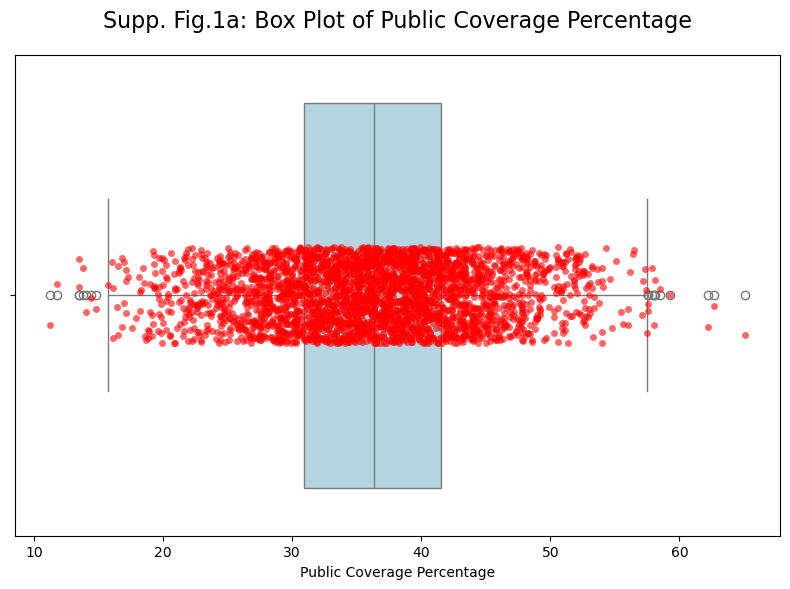

In [131]:
# Supp. Fig.1a: Box Plot with Strip Plot for pctpubliccoverage
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_combined['pctpubliccoverage'], color='lightblue')
sns.stripplot(x=df_combined['pctpubliccoverage'], color='red', alpha=0.6, jitter=True)
plt.title('Supp. Fig.1a: Box Plot of Public Coverage Percentage',fontsize=16, pad=20)
plt.xlabel('Public Coverage Percentage')

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.1a: Box_Plot_of_Public_Coverage_Percentage.png', bbox_inches='tight')

# Show the plot
plt.show()



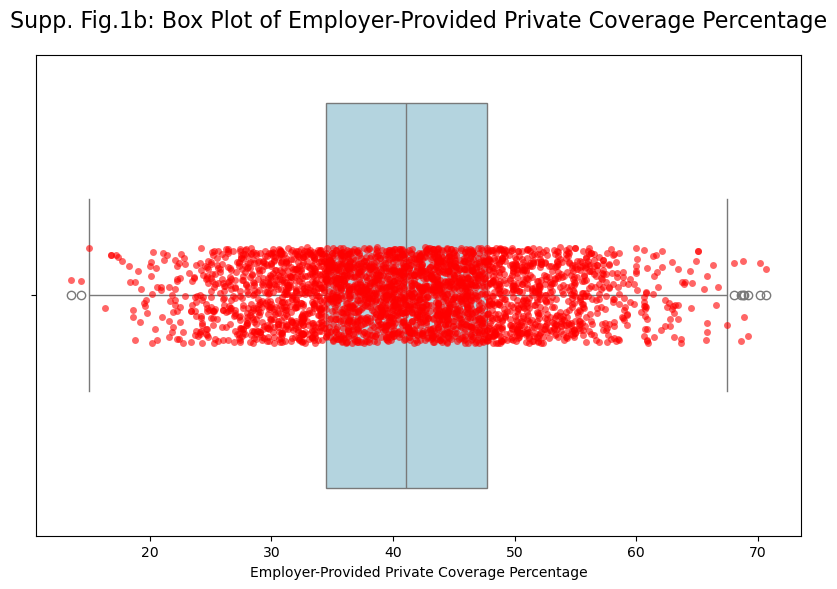

In [134]:
# Supp. Fig.1b: Box Plot with Strip Plot for pctempprivcoverage
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_combined['pctempprivcoverage'], color='lightblue')
sns.stripplot(x=df_combined['pctempprivcoverage'], color='red', alpha=0.6, jitter=True)
plt.title('Supp. Fig.1b: Box Plot of Employer-Provided Private Coverage Percentage',fontsize=16, pad=20)
plt.xlabel('Employer-Provided Private Coverage Percentage')

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.1b: Box_Plot_of_Employer-Provided_Private_Coverage_Percentage.png', bbox_inches='tight')

# Show the plot
plt.show()

In [135]:
# Supplemental Figure 2a and 2b:

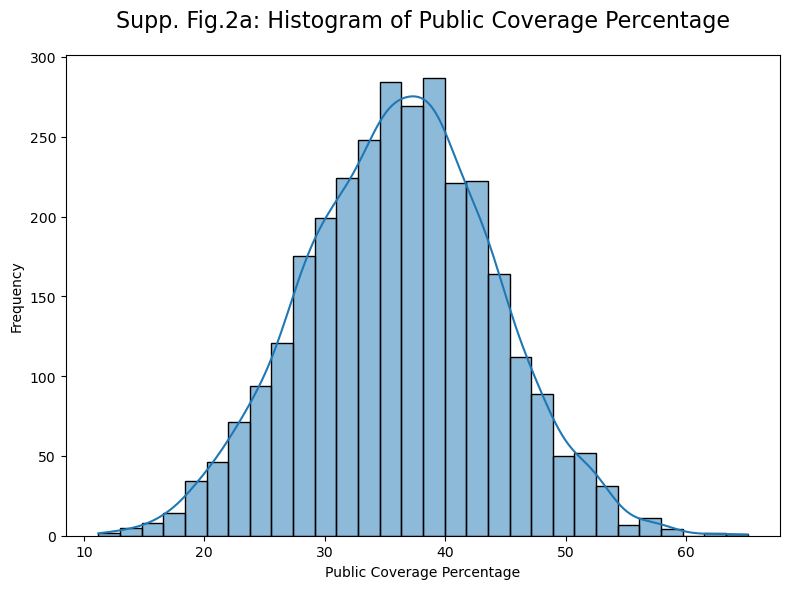

In [137]:
# Supp. Fig.2a: Histogram for pctpubliccoverage
plt.figure(figsize=(8, 6))
sns.histplot(df_combined['pctpubliccoverage'], bins=30, kde=True)
plt.title('Supp. Fig.2a: Histogram of Public Coverage Percentage',fontsize=16, pad=20)
plt.xlabel('Public Coverage Percentage')
plt.ylabel('Frequency')
# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.2a: Histogram_of_Public_Coverage_Percentage.png', bbox_inches='tight')

# Show the plot
plt.show()



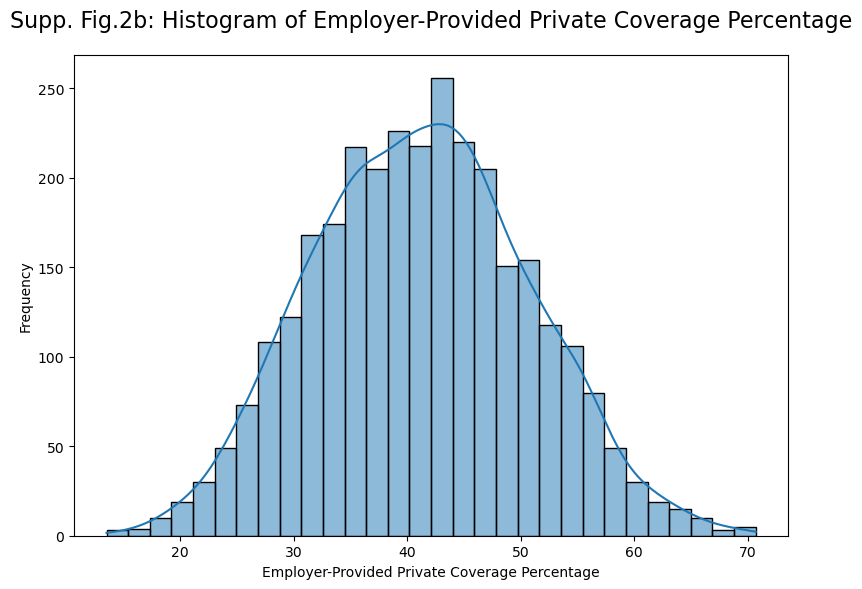

In [138]:
# Supp. Fig.2b: Histogram for pctempprivcoverage
plt.figure(figsize=(8, 6))
sns.histplot(df_combined['pctempprivcoverage'], bins=30, kde=True)
plt.title('Supp. Fig.2b: Histogram of Employer-Provided Private Coverage Percentage',fontsize=16, pad=20)
plt.xlabel('Employer-Provided Private Coverage Percentage')
plt.ylabel('Frequency')

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.2b: Histogram_of_Employer-Provided_Private_Coverage_Percentage.png', bbox_inches='tight')

# Show the plot
plt.show()

In [140]:
# Supplemental Figure 3a and 3b:

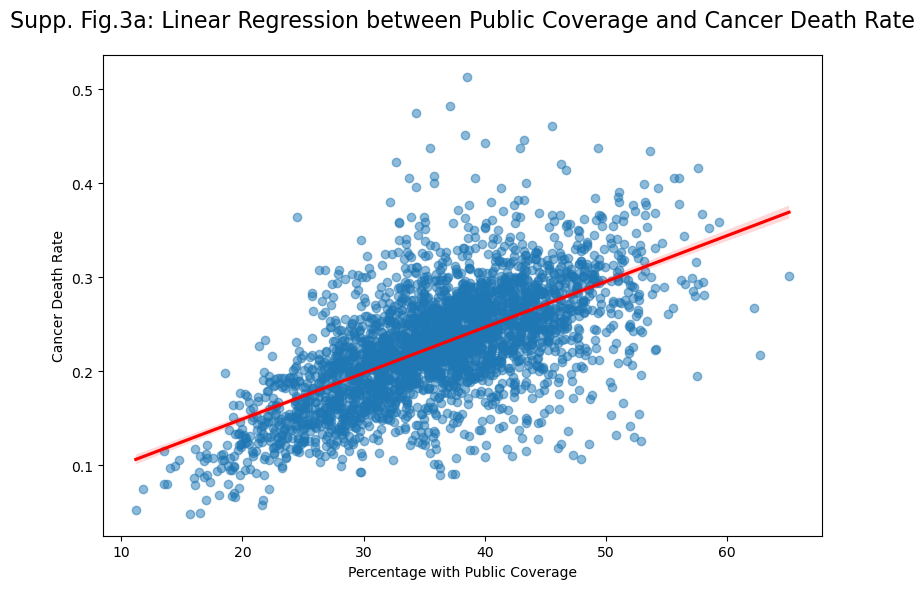

In [141]:
# Supp. Fig.3a: Linear Regression Plot for pctdeathrate vs pctpubliccoverage
plt.figure(figsize=(8, 6))
sns.regplot(x='pctpubliccoverage', y='pctdeathrate', data=df_combined, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Supp. Fig.3a: Linear Regression between Public Coverage and Cancer Death Rate',fontsize=16, pad=20)
plt.xlabel('Percentage with Public Coverage')
plt.ylabel('Cancer Death Rate')

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.3a: Linear_Regression_between_Public_Coverage_and_Cancer_Death_Rate.png', bbox_inches='tight')

# Show the plot
plt.show()


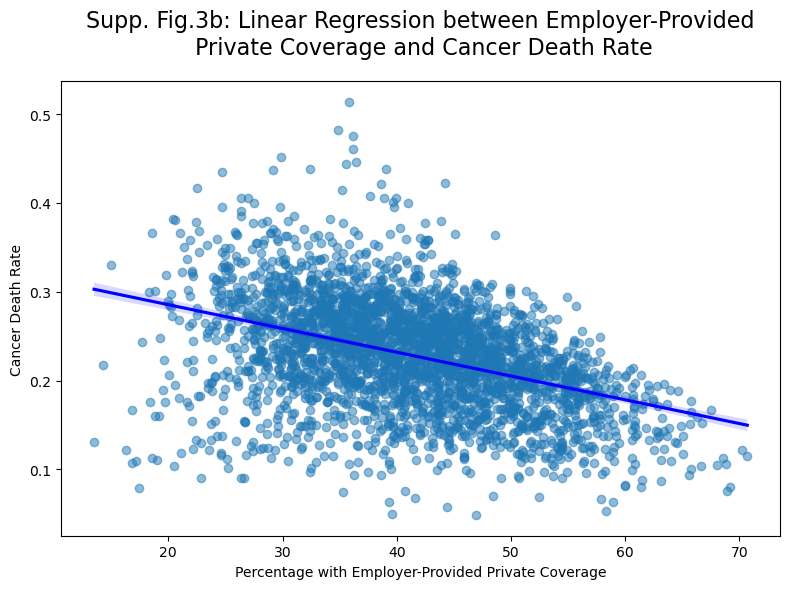

In [144]:
# Supp. Fig.3b: Linear Regression Plot for pctdeathrate vs pctempprivcoverage
plt.figure(figsize=(8, 6))
sns.regplot(x='pctempprivcoverage', y='pctdeathrate', data=df_combined, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('Supp. Fig.3b: Linear Regression between Employer-Provided\n Private Coverage and Cancer Death Rate',fontsize=16, pad=20)
plt.xlabel('Percentage with Employer-Provided Private Coverage')
plt.ylabel('Cancer Death Rate')

# Adjust layout before saving
plt.tight_layout()

# Save the plot before showing it
plt.savefig('results/figures/Supp. Fig.3b: Linear_Regression_between_Employer-Provided_Private_Coverage_and_Cancer_Death_Rate.png', bbox_inches='tight')

# Show the plot
plt.show()

In [146]:
# Supplemental Data:

In [147]:
# Skewness and Kurtosis for pctpubliccoverage
skewness_public = df_combined['pctpubliccoverage'].skew()
kurtosis_public = df_combined['pctpubliccoverage'].kurtosis()

print(f'Skewness of Public Coverage Percentage: {skewness_public}')
print(f'Kurtosis of Public Coverage Percentage: {kurtosis_public}')

# Skewness and Kurtosis for pctempprivcoverage
skewness_emppriv = df_combined['pctempprivcoverage'].skew()
kurtosis_emppriv = df_combined['pctempprivcoverage'].kurtosis()

# Create a DataFrame to display the skewness and kurtosis values
data = {
    'Metric': ['Skewness', 'Kurtosis'],
    'Public Coverage': [skewness_public, kurtosis_public],
    'Employer-Provided Private Coverage': [skewness_emppriv, kurtosis_emppriv]
}

df_metrics = pd.DataFrame(data)

# Display the table
print(df_metrics)

Skewness of Public Coverage Percentage: -0.005435599855118203
Kurtosis of Public Coverage Percentage: -0.08919408198606815
     Metric  Public Coverage  Employer-Provided Private Coverage
0  Skewness        -0.005436                            0.089416
1  Kurtosis        -0.089194                           -0.302237
